In [1]:
# TODO:
# naive overlap peaks that are not in IDR should be labeled as ambiguous, in addition to flanking bins
# barplot of cases 1 -4 , all performance metrics
# lower memory footprint for storing/reading hdf5 on Google Colab 
# Explain that hyperparameter search is performed online in similar way as Tut. 2. 
# Add calibration for the models. 
# Move the data zenodo. 
# Models in kipoi
# use nans to indicate ambiguous labels 
# resample validation to match test set imbalance 
# add in tensorboard integration 

# How to train your DragoNN tutorial 4: 
## Interpreting predictive sequence features in  TF binding events within the GM12878 cell line. 

This tutorial is a supplement to the DragoNN manuscript and follows figure 8 in the manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Generating positive and negative bins for genome-wide training </a></li>
    <li><a href=#3>Challenges of in vivo data : batch generators and class upsampling </a></li>
    <li><a href=#3.5>Optional: Download pre-generated models and test-set predictions </a></li>
    <li><a href=#4>Case 1: Negatives consist of shuffled references, single-tasked models</a></li>  
    <li><a href=#5>Case 2: Whole-genome negatives, single-tasked models </a></li>
    <li><a href=#6>Case 3: Whole-genome negatives, multi-tasked models </a></li>
    <li><a href=#7>Case 4: What happens if we don't upsample positive examples in our batches? </a></li>
    <li><a href=#8>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT </a></li>
    <li><a href=#9>Conclusions</a></li>    
    <li><a href=#10>Save tutorial outputs</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [2]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.2

In [3]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [4]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Input data <a name='1'>
<a href=#outline>Home</a>

Tutorials 1 - 3 have used simulated data generated with the simdna package. In this tutorial, we will examine how well CNN's are able to predict transcription factor binding for four TF's in vivo. 

We will learn to predict transcription factor binding for four transcription factors in the GM12878 cell line (one of the Tier 1 cell lines for the ENCODE project). First, we download the narrowPeak bed files for each of these transcription factors. You can skip the following code block if you already have the data downloaded. 

In [ ]:
## CTCF, optimal IDR thresholded peaks, Stam Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000DRZ/
!wget -O CTCF.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/ctcf_ENCSR000DRZ/cromwell-executions/chip/e94d720e-08dd-42fa-bc77-2391e2b8c275/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz 

## SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz
    
## ZNF143, optimal IDR thresholded peaks, Snyder lab, hg19
#https://www.encodeproject.org/experiments/ENCSR936XTK/
!wget -O ZNF143.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/znf143_ENCSR936XTK/cromwell-executions/chip/8e1d0af8-3ca6-44e2-aff0-af83b2c0c061/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

## SIX5, optimal IDR thresholded peaks, Myers Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BJE/
!wget -O SIX5.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/six5_ENCSR00BJE/cromwell-executions/chip/bd36ae6c-a9e3-4d71-a938-c45ab86854fc/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

## Download "ambiguous" peak sets -- these peaks are in the optimal overlap set across replicates, but are not
## found to be reproducible at a high confidence (p<0.05) by IDR 
! wget -O CTCF.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/CTCF.ambiguous.gz
! wget -O SPI1.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.ambiguous.gz
! wget -O ZNF143.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/ZNF143.ambiguous.gz
! wget -O SIX5.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SIX5.ambiguous.gz
    
## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
#!wget https://github.com/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.fai 


## Generating positive and negative bins for genome-wide training <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [5]:
from seqdataloader import * 

In [6]:
## seqdataloader accepts an input file, which we call tasks.tsv, with task names in column 1, the corresponding
## peak files in column 2, skip column 3 (which will be used for regression in Tutorial 5), and ambiguous peaks in 
## column4 
!echo "CTCF\tCTCF.narrowPeak.gz\t\tCTCF.ambiguous.gz" > tasks.tsv 
!echo "SPI1\tSPI1.narrowPeak.gz\t\tSPI1.ambiguous.gz" >> tasks.tsv 
!echo "SIX5\tSIX5.narrowPeak.gz\t\tSIX5.ambiguous.gz" >> tasks.tsv 
!echo "ZNF143\tZNF143.narrowPeak.gz\t\tZNF143.ambiguous.gz" >> tasks.tsv 
! cat tasks.tsv

CTCF	CTCF.narrowPeak.gz		CTCF.ambiguous.gz
SPI1	SPI1.narrowPeak.gz		SPI1.ambiguous.gz
SIX5	SIX5.narrowPeak.gz		SIX5.ambiguous.gz
ZNF143	ZNF143.narrowPeak.gz		ZNF143.ambiguous.gz


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* Each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. 

* The bin is labeled ambiguous (label = -1) and excluded from training if there is some overlap with the narrowPeak, but the peak summit does not lie in that overlap. 

* The bin is labeled negative if there is no overlap with the narrowPeak. 

In [ ]:
#we will include all chromosomes with the exception of 1,2, and 19 in our training set 

#1) Generate genome-wide negatives in addition to positives 
train_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'    
    }
genomewide_labels(train_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 

positives_train_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_train_set_params)

In [ ]:
#We will include chromsome 1 in our validation set 

#1) Generate genome-wide negatives in addition to positives 
valid_set_params={'task_list':"tasks.tsv",
    'outf':"TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)


#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_valid_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_valid_set_params)


In [ ]:
#We will include chromosomes 2 and 19 in our testing set 
test_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_test_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_test_set_params)


Let's examine the files that were generated: 

In [7]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("TF.train.hdf5",start=0,stop=10)

CTCF  SPI1  SIX5  ZNF143
CHR  START END                           
chr3 0     1000   0.0   0.0   0.0     0.0
     50    1050   0.0   0.0   0.0     0.0
     100   1100   0.0   0.0   0.0     0.0
     150   1150   0.0   0.0   0.0     0.0
     200   1200   0.0   0.0   0.0     0.0
     250   1250   0.0   0.0   0.0     0.0
     300   1300   0.0   0.0   0.0     0.0
     350   1350   0.0   0.0   0.0     0.0
     400   1400   0.0   0.0   0.0     0.0
     450   1450   0.0   0.0   0.0     0.0

In [8]:
# When provided with the --store-positives_only flag, the code generates all bins for each task that are labeled positive.
pd.read_hdf("SPI1.positives.TF.train.hdf5",start=0,stop=10)

SPI1
CHR  START  END         
chr3 129600 130600   1.0
     129650 130650   1.0
     129700 130700   1.0
     129750 130750   1.0
     260300 261300   1.0
     260350 261350   1.0
     260400 261400   1.0
     260450 261450   1.0
     319100 320100   1.0
     319150 320150   1.0

In [9]:
#We load our test set labels into memory here, as we will use them to measure performance in cases 1 - 4 below.
#Note that we only load the labels into memory, not the actual test dataset. 

#It is not necessary to load the training/validation dataset or labels, see below. 
test_set=pd.read_hdf("TF.test.hdf5")
test_set

CTCF  SPI1  SIX5  ZNF143
CHR   START    END                               
chr2  0        1000       0.0   0.0   0.0     0.0
      50       1050       0.0   0.0   0.0     0.0
      100      1100       0.0   0.0   0.0     0.0
      150      1150       0.0   0.0   0.0     0.0
      200      1200       0.0   0.0   0.0     0.0
      250      1250       0.0   0.0   0.0     0.0
      300      1300       0.0   0.0   0.0     0.0
      350      1350       0.0   0.0   0.0     0.0
      400      1400       0.0   0.0   0.0     0.0
      450      1450       0.0   0.0   0.0     0.0
      500      1500       0.0   0.0   0.0     0.0
      550      1550       0.0   0.0   0.0     0.0
      600      1600       0.0   0.0   0.0     0.0
      650      1650       0.0   0.0   0.0     0.0
      700      1700       0.0   0.0   0.0     0.0
      750      1750       0.0   0.0   0.0     0.0
      800      1800       0.0   0.0   0.0     0.0
      850      1850       0.0   0.0   0.0     0.0
      900      1900       0.0   0.0   0.0     0.0
      950      1950       0.0   0.0   0.0     0.0
      1000     2000       0.0   0.0   0.0     0.0
      1050     2050       0.0   0.0   0.0     0.0
      1100     2100       0.0   0.0   0.0     0.0
      1150     2150       0.0   0.0   0.0     0.0
      1200     2200       0.0   0.0   0.0     0.0
      1250     2250       0.0   0.0   0.0     0.0
      1300     2300       0.0   0.0   0.0     0.0
      1350     2350       0.0   0.0   0.0     0.0
      1400     2400       0.0   0.0   0.0     0.0
      1450     2450       0.0   0.0   0.0     0.0
...                       ...   ...   ...     ...
chr19 59126500 59127500   0.0   0.0   0.0     0.0
      59126550 59127550   0.0   0.0   0.0     0.0
      59126600 59127600   0.0   0.0   0.0     0.0
      59126650 59127650   0.0   0.0   0.0     0.0
      59126700 59127700   0.0   0.0   0.0     0.0
      59126750 59127750   0.0   0.0   0.0     0.0
      59126800 59127800   0.0   0.0   0.0     0.0
      59126850 59127850   0.0   0.0   0.0     0.0
      59126900 59127900   0.0   0.0   0.0     0.0
      59126950 59127950   0.0   0.0   0.0     0.0
      59127000 59128000   0.0   0.0   0.0     0.0
      59127050 59128050   0.0   0.0   0.0     0.0
      59127100 59128100   0.0   0.0   0.0     0.0
      59127150 59128150   0.0   0.0   0.0     0.0
      59127200 59128200   0.0   0.0   0.0     0.0
      59127250 59128250   0.0   0.0   0.0     0.0
      59127300 59128300   0.0   0.0   0.0     0.0
      59127350 59128350   0.0   0.0   0.0     0.0
      59127400 59128400   0.0   0.0   0.0     0.0
      59127450 59128450   0.0   0.0   0.0     0.0
      59127500 59128500   0.0   0.0   0.0     0.0
      59127550 59128550   0.0   0.0   0.0     0.0
      59127600 59128600   0.0   0.0   0.0     0.0
      59127650 59128650   0.0   0.0   0.0     0.0
      59127700 59128700   0.0   0.0   0.0     0.0
      59127750 59128750   0.0   0.0   0.0     0.0
      59127800 59128800   0.0   0.0   0.0     0.0
      59127850 59128850   0.0   0.0   0.0     0.0
      59127900 59128900   0.0   0.0   0.0     0.0
      59127950 59128950   0.0   0.0   0.0     0.0

[6046528 rows x 4 columns]

## Challenges of in vivo data : batch generators and class upsampling <a name='3'>
<a href=#outline>Home</a>

In tutorials 1 - 3, we used the [keras fit](https://keras.io/models/sequential/#fit) function to train a CNN. However, when working with real data we face two new challenges: 

1) The dataset is much bigger. In our training set, there are 50,881,560 1kb bins, in our validation set, there are 4,984,994 bins, and in our test set there are 6,046,529 bins. Loading this dataset into memory to pass as a numpy array to the CNN code will require more memory than is available on many machines. Consequently, we use the [keras fit_generator](https://keras.io/models/sequential/#fit_generator) function to limit the memory footprint. This function reads in one batch of training and one batch of validation data at a time from a python generator. in *dragonn.generators*, we provide several python generator functions to match the scenarios below. 

In [10]:
from dragonn.generators import * 

2) The dataset is highly imbalanced. Of the 50,881,559 1kb bins in the training set, only 

* 138,399 are labeled positive for the SPI1 task (367 negatives: 1 positive )

* 131,033 are labeled positive for the CTCF task (388 negatives: 1 positive ) 

* 88,541 are labeled positive for the ZNF143 task (574 negatives: 1 positive ) 

* 15,630 are labeled positive for the SIX5 task (3255 negatives: 1 positive ) 

The class imbalance is far too high for the model to learn unassisted. Hence, we upsample the positive bins to include in each batch with the "upsample" argument to DataGenerator. The upsample argument accepts a fraction between 0 and 1 and ensures that this fraction of the batch consists of positive bins. 


In [24]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History, TensorBoard 
from keras import backend as K 
K.set_image_data_format('channels_last')

#we use a custom binary cross-entropy loss that can handle ambiguous labels (denoted with -1 ) and exclude them 
# from the loss calculation 
from dragonn.custom_losses import get_ambig_binary_crossentropy

In [12]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.constraints import max_norm

def initialize_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))
    
    #use the custom ambig_binary_crossentropy loss, indicating that a value of -1 indicates an ambiguous label 
    loss=get_ambig_binary_crossentropy(-1)
    
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss=loss,
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

### Download pre-generated models and test set predictions (optional) <a name='3.5'>
<a href=#outline>Home</a>

#### **Note: on a GPU, each of the models below should take 10 - 15 minutes to train, with an additional 7-10 minutesu for prediction on the corresponding test sets. Although training the models is a valuable exercise, for the sake of time, we also provide hdf5 files with pre-trained models and test set predictions. These were generated by running the tutorial and saving the outputs at the end (see <a href=#10>Save tutorial outputs</a>). Uncomment the cell below if you wish to load the pre-trained models and test set predictions to use for performance comparison and DeepLIFT analyis** 

In [13]:
#Download the models 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case3_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case4_spi1_model.hdf5
    


In [14]:
#Load the models from hdf5 
#from keras.models import load_model 
#case1_spi1_model=load_model("case1_spi1_model.hdf5")
#case1_ctcf_model=load_model("case1_ctcf_model.hdf5")
#case2_spi1_model=load_model("case2_spi1_model.hdf5")
#case2_ctcf_model=load_model("case2_ctcf_model.hdf5")
#case3_model=load_model("case3_model.hdf5")
#case4_spi1_model=load_model("case4_spi1_model.hdf5")


In [15]:

#Download test set predictions 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/test_set_predictions.hdf5


In [16]:
#Extract predictions from hdf5 for each model 
#import h5py
#test_set_predictions=h5py.File("test_set_predictions.hdf5")


In [17]:
#case1_spi1_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case1_ctcf_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case2_spi1_test_predictions=test_set_predictions["case2_spi1_test_predictions"].value
#case2_ctcf_test_predictions=test_set_predictions["case2_ctcf_test_predictions"].value
#case3_test_predictions=test_set_predictions["case3_test_predictions"].value
#case4_spi1_test_predictions=test_set_predictions["case4_spi1_test_predictions"].value

In [18]:
#case1_spi1_test_predictions.shape

## Case 1: Negatives consist of shuffled references, single-tasked models<a name='4'>
<a href=#outline>Home</a>

We begin by training a model on the SPI1 and CTCF dataset with the following specifications: 

* We use dinucleotide-shuffled positive bins as the negative set. 

* Each batch contains one-hot encoded 1kb regions from the genome, as well as the one-hot-encoded reverse complement sequences of those regions. 


We create generators for the training and validation data to meet these specifications: 

In [19]:
#create the generators
from dragonn.generators import * 
case1_spi1_train_gen=DataGenerator("SPI1.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_spi1_valid_gen=DataGenerator("SPI1.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_ctcf_train_gen=DataGenerator("CTCF.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_ctcf_valid_gen=DataGenerator("CTCF.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)

We now follow the standard protocol we used in tutorials 1 - 3 to train a keras model, with the exception that we use the fit_generator function in keras, rather than the fit function.

In [25]:
callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()]

In [26]:
#If you are running this notebook in google colab, uncomment the lines below to observe the model's training 
#!mkdir logs
#%tensorboard --logdir logs 
#tensorboard_visualizer=TensorBoard(log_dir="logs", histogram_freq=0, batch_size=500, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#callbacks.append(tensorboard_visualizer)

In [27]:
#Train the SPI1 model 
case1_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_spi1=case1_spi1_model.fit_generator(case1_spi1_train_gen,
                                                  validation_data=case1_spi1_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=callbacks)

Epoch 1/150
2156/2156 [==============================] - 94s 43ms/step - loss: 0.0321 - sensitivity: 0.9871 - specificity: 0.9902 - fpr: 0.0098 - fnr: 0.0129 - precision: 0.9898 - f1: 0.9883 - val_loss: 0.2462 - val_sensitivity: 0.8540 - val_specificity: 1.0000 - val_fpr: 3.0800e-05 - val_fnr: 0.1460 - val_precision: 1.0000 - val_f1: 0.9190
Epoch 2/150
2156/2156 [==============================] - 89s 41ms/step - loss: 0.0075 - sensitivity: 0.9974 - specificity: 0.9977 - fpr: 0.0023 - fnr: 0.0026 - precision: 0.9977 - f1: 0.9976 - val_loss: 0.0135 - val_sensitivity: 0.9976 - val_specificity: 0.9933 - val_fpr: 0.0067 - val_fnr: 0.0024 - val_precision: 0.9934 - val_f1: 0.9955
Epoch 3/150
2156/2156 [==============================] - 93s 43ms/step - loss: 0.0060 - sensitivity: 0.9979 - specificity: 0.9979 - fpr: 0.0021 - fnr: 0.0021 - precision: 0.9979 - f1: 0.9979 - val_loss: 0.0185 - val_sensitivity: 0.9889 - val_specificity: 0.9997 - val_fpr: 2.7720e-04 - val_fnr: 0.0111 - val_precision:

In [28]:
#Train the CTCF model 
case1_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_ctcf=case1_ctcf_model.fit_generator(case1_ctcf_train_gen,
                                                  validation_data=case1_ctcf_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=callbacks)

Epoch 1/150
2047/2047 [==============================] - 99s 49ms/step - loss: 0.0386 - sensitivity: 0.9826 - specificity: 0.9902 - fpr: 0.0098 - fnr: 0.0174 - precision: 0.9887 - f1: 0.9847 - val_loss: 4.7725 - val_sensitivity: 1.0000 - val_specificity: 0.0225 - val_fpr: 0.9775 - val_fnr: 0.0000e+00 - val_precision: 0.5058 - val_f1: 0.6717
Epoch 1/150
Epoch 2/150
2047/2047 [==============================] - 92s 45ms/step - loss: 0.0090 - sensitivity: 0.9969 - specificity: 0.9971 - fpr: 0.0029 - fnr: 0.0031 - precision: 0.9971 - f1: 0.9970 - val_loss: 0.0083 - val_sensitivity: 0.9966 - val_specificity: 0.9978 - val_fpr: 0.0022 - val_fnr: 0.0034 - val_precision: 0.9978 - val_f1: 0.9972
Epoch 3/150
2047/2047 [==============================] - 94s 46ms/step - loss: 0.0060 - sensitivity: 0.9981 - specificity: 0.9980 - fpr: 0.0020 - fnr: 0.0019 - precision: 0.9980 - f1: 0.9980 - val_loss: 0.0514 - val_sensitivity: 0.9999 - val_specificity: 0.9659 - val_fpr: 0.0341 - val_fnr: 6.3763e-05 - va

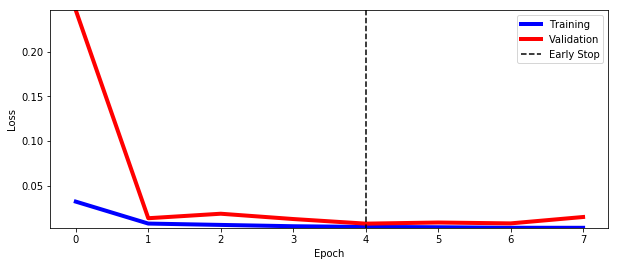

In [29]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_case1_spi1)

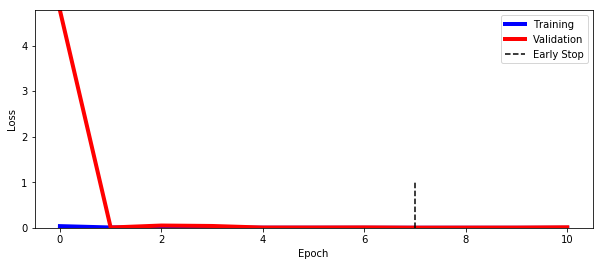

In [30]:
## Plot the learning curve for CTCF 
plot_learning_curve(history_case1_ctcf)

We now measure how well the models performed by calculating performance metrics on the test splits across the whole genome. 

In [31]:
case1_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case1_spi1_test_predictions=case1_spi1_model.predict_generator(case1_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6047/6047 [==============================] - 425s 70ms/step


In [32]:
case1_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case1_ctcf_test_predictions=case1_ctcf_model.predict_generator(case1_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6047/6047 [==============================] - 459s 76ms/step


In [33]:
#format true & predicted test labels for performance assessment 

#if test_set.shape is not a multiple of batch_size, 
#there may be some extra values in test_set that need to get truncated.
spi1_test_truth=np.expand_dims(test_set['SPI1'][0:case1_spi1_test_predictions.shape[0]],1).astype(bool)

In [34]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_truth,case1_spi1_test_predictions))

Loss: nan	Balanced Accuracy: 50.81%	 auROC: 0.631	 auPRC: 0.007
	Recall at 5%|10%|20% FDR: 0.3%|0.0%|0.0%	 Num Positives: 0.0	 Num Negatives: 30779


In [35]:
ctcf_test_truth=np.expand_dims(test_set['CTCF'][0:case1_ctcf_test_predictions.shape[0]],1).astype(bool)

In [36]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case1_ctcf_test_predictions))

Loss: nan	Balanced Accuracy: 51.42%	 auROC: 0.694	 auPRC: 0.011
	Recall at 5%|10%|20% FDR: 0.3%|0.0%|0.0%	 Num Positives: 0.0	 Num Negatives: 37131


## Case 2: Whole-genome negatives, single-tasked models <a name='5'>
<a href=#outline>Home</a>

* Since the genomewide imbalance of negative bins to positive bins is very high, we upsample each batch in the training set to contain 30% positive samples. 

In [ ]:
#create the generators
from dragonn.generators import * 
case2_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.3,batch_size=256)
case2_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False,batch_size=256)
case2_ctcf_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.3,batch_size=256)
case2_ctcf_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample=False,batch_size=256)


In [ ]:
#Train the SPI1 model 
case2_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_spi1=case2_spi1_model.fit_generator(case2_spi1_train_gen,
                                                  validation_data=case2_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
#Train the CTCF model 
case2_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_ctcf=case2_ctcf_model.fit_generator(case2_ctcf_train_gen,
                                                  validation_data=case2_ctcf_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case2_spi1)

In [ ]:
## Plot the learning curves for CTCF  
plot_learning_curve(history_case2_ctcf)

In [ ]:
#Get model predictions on the test set 
case2_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case2_spi1_test_predictions=case2_spi1_model.predict_generator(case2_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


In [ ]:
case2_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case2_ctcf_test_predictions=case2_ctcf_model.predict_generator(case2_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


In [ ]:
from dragonn.metrics import ClassificationResult
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case2_spi1_test_predictions))

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case2_ctcf_test_predictions))

## Case 3: Whole-genome negatives, multi-tasked models <a name='6'>
<a href=#outline>Home</a>

In [ ]:
#create the generators for multi-tasked models. Guarantee 10% positives in each batch 
case3_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,batch_size=256)
case3_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",upsample=False,batch_size=256)

In [ ]:
#Train the SPI1 model 
case3_model=initialize_model(4)

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case3=case3_model.fit_generator(case3_train_gen,
                                        validation_data=case3_valid_gen,
                                        steps_per_epoch=10000,
                                        validation_steps=5000,
                                        epochs=150,
                                        verbose=1,
                                        use_multiprocessing=True,
                                        workers=40,
                                        max_queue_size=100,
                                        callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
## Plot the learning curves for the multi-tasked model   
plot_learning_curve(history_case3)

In [ ]:
case3_test_gen=DataGenerator("TF.test.hdf5",
                             "hg19.genome.fa.gz",
                             upsample=False,
                             add_revcomp=False,
                             batch_size=1000)
case3_test_predictions=case3_model.predict_generator(case3_test_gen,
                                                     max_queue_size=5000, 
                                                     workers=40, 
                                                     use_multiprocessing=True, 
                                                     verbose=1)


In [ ]:
test_truth=test_set[0:case3_test_predictions.shape[0]].astype(bool)

In [ ]:
test_truth.columns

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SPI1'],1),
                           np.expand_dims(case3_test_predictions[:,0],1)))

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['CTCF'],1),
                           np.expand_dims(case3_test_predictions[:,1],1)))

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['ZNF143'],1),
                           np.expand_dims(case3_test_predictions[:,2],1)))

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SIX5'],1),
                           np.expand_dims(case3_test_predictions[:,3],1)))

## Case 4: What happens if we don't upsample positive examples in our batches? <a name='7'>
<a href=#outline>Home</a>

In [ ]:
#create the generators
case4_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False,batch_size=256)
case4_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False,batch_size=256)

In [ ]:
#Train the SPI1 model 
case4_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case4_spi1=case4_spi1_model.fit_generator(case4_spi1_train_gen,
                                                  validation_data=case4_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case4_spi1)

In [ ]:
#We  use a custom batch_predict function to generate predictions on the test set, one batch at a time 
case4_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case4_spi1_test_predictions=case4_spi1_model.predict_generator(case4_spi1_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


In [ ]:

## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case4_spi1_test_predictions))


## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='8'>
<a href=#outline>Home</a>

The highest test set auPRC was observed in Case 2 -- the single-tasked, genome-wide, SPI1 model with upsampling of positives. Let's run DeepLIFT on some high-confidence true positives. 


In [ ]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
true_pos_spi1=test_truth[spi1_test_truth*case2_spi1_test_predictions >0.9]
true_pos_spi1.head

In [ ]:
true_pos_spi1.shape

In [ ]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

In [ ]:
from dragonn.tutorial_utils import deeplift 

In [ ]:
deep_lift_scores_spi1=deeplift(case2_spi1_model,deep_lift_input_spi1)

In [ ]:
deep_lift_scores_spi1.shape

Let's plot a few of the DeepLIFT tracks and see if the model successfully learned SPI1:

In [ ]:
from dragonn.tutorial_utils import  plot_seq_importance

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

Let's zoom in to the center of one sequence so that it is easier to distinguish the motif: 

In [ ]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[450:550],deep_lift_input_spi1[2].squeeze()[450:550])

If we query the sequence "TCACTTCCCCTT" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for SPIB (p-value = 8.93e-7): 
<img src="tutorial_images/SPI1.Tut4.png" alt="SPI1TomTom" width="400"/>


Let's interpret the high-confidence true positives from the CTCF model

In [ ]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence predictions)
true_pos_ctcf=test_truth[ctcf_test_truth*case2_ctcf_test_predictions >0.9]
true_pos_ctcf.shape

In [ ]:
deep_lift_input_ctcf=one_hot_from_bed([i for i in true_pos_ctcf.index],"hg19.genome.fa.gz")

In [ ]:
deep_lift_scores_ctcf=deeplift(case2_ctcf_model,deep_lift_input_ctcf)

In [ ]:
plot_seq_importance(deep_lift_scores_ctcf[0],deep_lift_input_ctcf[0])

In [ ]:
plot_seq_importance(deep_lift_scores_ctcf[1],deep_lift_input_ctcf[1])

In [ ]:
plot_seq_importance(deep_lift_scores_ctcf[2],deep_lift_input_ctcf[2])

Zooming in:

In [ ]:
plot_seq_importance(deep_lift_scores_ctcf[0].squeeze()[500:600],deep_lift_input_ctcf[0].squeeze()[500:600])

Querying the sequence "GCGCCCTCTGCTGG" in TomTom confirms a strong match (p=1.43e-6) to the canonical CTCF motif:
<img src="tutorial_images/CTCF.Tut4.png" alt="CTCFTomTom" width="400"/>


## Conclusions <a name='9'>
<a href=#outline>Home</a>

From our analysis of *in vivo* transcription factor ChiP-seq datasets, we draw the following conclusions: 

* Training the models genome-wide by splitting the genome into short (200 bp), overlapping (stride=50) bins leads to improved generalization performance on the test set as compared to "easier" negative sets. I.E we observed superior test set performance for both the SPI1 and CTCF tasks when training on the whole genome as compared to using shuffled reference negatives. 


* Due to high class imbalance in *in vivo* data, it is necessary to upsample positive examples in each batch to facilitate model training. We found that upsampling positives to constitute 30% of each batch worked well --i.e. interpretation with DeepLIFT indicates the model learned the correct motif in CTCF and SPI1 ChIP-seq datasets. What happens if you alter the *upsample_ratio* parameter in the generator function? Does the model learn equally well with *upsample_ratio=0.1*? Does it learn better or worse with *upsample_ratio=0.5*? 


* Multi-tasking can lead to improved performance for tasks that are similar (i.e. CTCF/ZNF143/SIX5 are similar motifs). However, multi-tasking does not improve performance on tasks that are different (i.e. the SPI1 motif does not resemble the other three motifs, so multi-tasking does not improve performance for the SPI1 task). 


## Save tutorial outputs <a name='10'>
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [ ]:
#save the models 
case1_spi1_model.save("case1_spi1_model.hdf5")
case1_ctcf_model.save("case1_ctcf_model.hdf5")
case2_spi1_model.save("case2_spi1_model.hdf5")
case2_ctcf_model.save("case2_ctcf_model.hdf5")
case3_model.save("case3_model.hdf5")
case4_spi1_model.save("case4_spi1_model.hdf5")

In [ ]:
#save the test set predictions 
import h5py 
test_set_predictions=h5py.File("test_set_predictions.hdf5",'w')
test_set_predictions.create_dataset("case1_spi1_test_predictions",data=case1_spi1_test_predictions)
test_set_predictions.create_dataset("case1_ctcf_test_predictions",data=case1_ctcf_test_predictions)
test_set_predictions.create_dataset("case2_spi1_test_predictions",data=case2_spi1_test_predictions)
test_set_predictions.create_dataset("case2_ctcf_test_predictions",data=case2_ctcf_test_predictions)
test_set_predictions.create_dataset("case3_test_predictions",data=case3_test_predictions)
test_set_predictions.create_dataset("case4_spi1_test_predictions",data=case4_spi1_test_predictions)
test_set_predictions.close() 